In [2]:
# 欠拟合和过拟合
# http://zh.gluon.ai/chapter_supervised-learning/underfit-overfit.html

from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

num_train = 100
num_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5.0

In [3]:
x = nd.random.normal(shape=(num_train+num_test, 1))
X = nd.concat(x, nd.power(x, 2), nd.power(x, 3))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_w[2] * X[:, 2] + true_b
y += .1 * nd.random.normal(shape=y.shape)

('x:', x[:5], 'X:', X[:5], 'y:', y[:5])

('x:', 
 [[ 0.32510808]
  [-1.3002341 ]
  [ 0.3679345 ]
  [ 1.4534262 ]
  [ 0.24154152]]
 <NDArray 5x1 @cpu(0)>, 'X:', 
 [[ 0.32510808  0.10569526  0.03436238]
  [-1.3002341   1.6906086  -2.1981869 ]
  [ 0.3679345   0.1353758   0.04980943]
  [ 1.4534262   2.1124477   3.0702872 ]
  [ 0.24154152  0.0583423   0.01409209]]
 <NDArray 5x3 @cpu(0)>, 'y:', 
 [  5.220803  -14.51063     5.133296   16.672255    5.3098583]
 <NDArray 5 @cpu(0)>)

In [4]:
# 定义训练和测试步骤
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

def train(X_train, X_test, y_train, y_test):
    # 线性回归模型
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    
    # 设一些默认参数
    learning_rate = 0.01
    epochs = 100
    batch_size = min(10, y_train.shape[0])
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size, shuffle=True)
    
    # 默认SGD和均方误差
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate
    })
    square_loss = gluon.loss.L2Loss()
    
    # 保存训练和测试损失
    train_loss =[]
    test_loss = []
    for e in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
        train_loss.append(square_loss(net(X_train), y_train).mean().asscalar())
        test_loss.append(square_loss(net(X_test), y_test).mean().asscalar())
        
    # 打印结果
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train', 'test'])
    plt.show()
    return ('learned weight', net[0].weight.data(),
           'learned bias', net[0].bias.data())

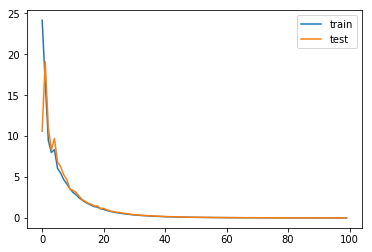

('learned weight', 
 [[ 1.3098607 -3.337205   5.574892 ]]
 <NDArray 1x3 @cpu(0)>, 'learned bias', 
 [4.908364]
 <NDArray 1 @cpu(0)>)

In [10]:
# 三阶多项式拟合（正常）
# print(X.shape, X[:num_train, :].shape, X[num_train:, :].shape)
# print(y.shape, y[:num_train].shape, y[num_train:].shape)
train(X[:num_train, :], X[num_train:, :], y[:num_train], y[num_train:])

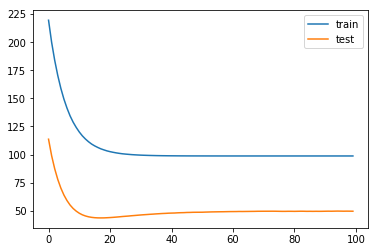

('learned weight', 
 [[18.253834]]
 <NDArray 1x1 @cpu(0)>, 'learned bias', 
 [2.2087626]
 <NDArray 1 @cpu(0)>)

In [12]:
# 线性拟合（欠拟合）
train(x[:num_train, :], x[num_train:, :], y[:num_train], y[num_train:])

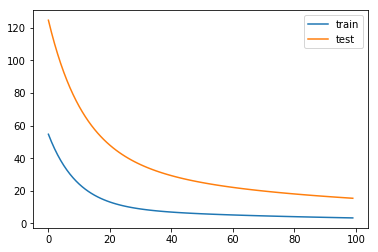

('learned weight', 
 [[ 2.7471938 -2.2967875  3.4228234]]
 <NDArray 1x3 @cpu(0)>, 'learned bias', 
 [0.80204546]
 <NDArray 1 @cpu(0)>)

In [13]:
# 训练量不足（过拟合）
train(X[0:2, :], X[num_train:, :], y[0:2], y[num_train:])